In [2]:
import os
import numpy as np
import cv2
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


In [3]:
from google.colab import files
uploaded = files.upload()


Saving archive_(11).zip to archive_(11).zip


In [5]:
import zipfile
import os

zip_path = "archive_(11).zip"  # Make sure the name matches exactly
extract_path = "/content/dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(" Extracted folders:", os.listdir(extract_path))


 Extracted folders: ['data']


In [6]:
for root, dirs, files in os.walk(extract_path):
    print( root)
    if any(f.lower().endswith(('.jpg', '.png')) for f in files):
        break

📁 /content/dataset
📁 /content/dataset/data
📁 /content/dataset/data/non-vehicles


In [7]:
data_dir = "/content/dataset/data"

In [9]:

image_size = 150
image_data = []
label_data = []

labels = [folder for folder in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, folder))]
print(f"Found classes: {labels}")

for label in labels:
    folder_path = os.path.join(data_dir, label)
    for file in tqdm(os.listdir(folder_path), desc=f"Loading {label}"):
        img_path = os.path.join(folder_path, file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (image_size, image_size))
            image_data.append(img)
            label_data.append(label)

image_data = np.array(image_data)
label_data = np.array(label_data)


Found classes: ['non-vehicles', 'vehicles']


Loading vehicles: 100%|██████████| 8792/8792 [00:02<00:00, 3739.85it/s]


In [10]:
# Shuffle
image_data, label_data = shuffle(image_data, label_data, random_state=42)

# Encode labels to one-hot
le = LabelEncoder()
labels_encoded = le.fit_transform(label_data)
labels_encoded = to_categorical(labels_encoded)

# Split: 70% train, 10% val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(image_data, labels_encoded, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, random_state=42)

print(f"Train shape: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


Train shape: (12432, 150, 150, 3), Val: (1776, 150, 150, 3), Test: (3552, 150, 150, 3)


In [11]:
def build_model(base_model_class, input_shape, num_classes):
    base_model = base_model_class(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [18]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# VGG16
vgg_model = build_model(VGG16, (150, 150, 3), len(labels))
vgg_history = vgg_model.fit(X_train, y_train, validation_data=(X_val, y_val),
                            epochs=20, batch_size=32, callbacks=[early_stop])


Epoch 1/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 47s 117ms/step - accuracy: 0.9570 - loss: 0.1590 - val_accuracy: 0.9949 - val_loss: 0.0252
Epoch 2/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 79s 112ms/step - accuracy: 0.9976 - loss: 0.0080 - val_accuracy: 0.9977 - val_loss: 0.0096
Epoch 3/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 87s 125ms/step - accuracy: 0.9982 - loss: 0.0059 - val_accuracy: 0.9949 - val_loss: 0.0151
Epoch 4/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 48s 124ms/step - accuracy: 0.9988 - loss: 0.0036 - val_accuracy: 0.9955 - val_loss: 0.0110
Epoch 5/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 82s 125ms/step - accuracy: 0.9999 - loss: 4.0446e-04 - val_accuracy: 0.9966 - val_loss: 0.0080
Epoch 6/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 82s 125ms/step - accuracy: 1.0000 - loss: 1.5771e-04 - val_accuracy: 0.9983 - val_loss: 0.0066
Epoch 7/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 48s 124ms/step - accuracy: 1.0000 - loss: 9.6765e-05 - val_accuracy: 0.9966 - val_loss: 0.0071
Epoch 8/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 82s 125ms/step - accuracy: 1.00

In [19]:
print("Final Test Evaluation:")
vgg_model.evaluate(X_test, y_test)


Final Test Evaluation:
111/111 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step - accuracy: 0.9978 - loss: 0.0074


[0.015957681462168694, 0.9974662065505981]

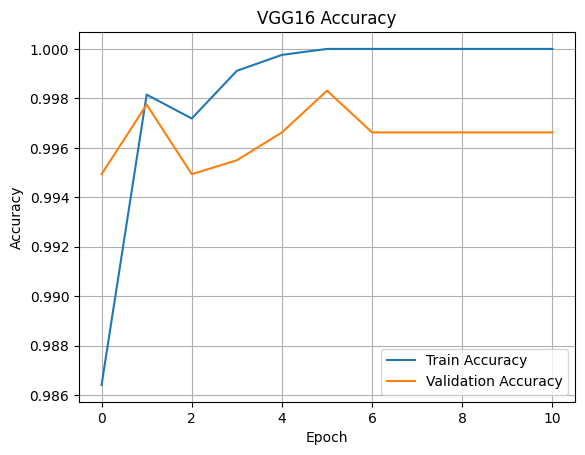

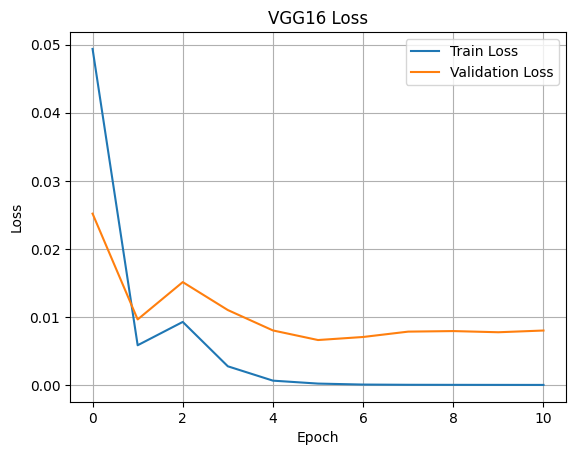

In [20]:
# Accuracy
plt.plot(vgg_history.history['accuracy'], label='Train Accuracy')
plt.plot(vgg_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('VGG16 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(vgg_history.history['loss'], label='Train Loss')
plt.plot(vgg_history.history['val_loss'], label='Validation Loss')
plt.title('VGG16 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [16]:
#Building a RestNet50 Model

def build_model(base_model_class, input_shape, num_classes):
    base_model = base_model_class(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [17]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [21]:
# Build and train ResNet50
resnet_model = build_model(ResNet50, (150, 150, 3), len(labels))

resnet_history = resnet_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop]
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/30
389/389 ━━━━━━━━━━━━━━━━━━━━ 40s 75ms/step - accuracy: 0.9838 - loss: 0.0383 - val_accuracy: 1.0000 - val_loss: 8.1983e-04
Epoch 2/30
389/389 ━━━━━━━━━━━━━━━━━━━━ 27s 50ms/step - accuracy: 0.9985 - loss: 0.0030 - val_accuracy: 0.9989 - val_loss: 0.0044
Epoch 3/30
389/389 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.9995 - loss: 0.0024 - val_accuracy: 0.9921 - val_loss: 0.0272
Epoch 4/30
389/389 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.9994 - loss: 0.0011 - val_accuracy: 0.9994 - val_loss: 0.0018
Epoch 5/30
389/389 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.9999 - loss: 6.1073e-04 - val_accuracy: 0.9994 - val_loss: 0.0044
Epoch 6/30
389/389 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 1.0000 - loss: 2.0620e-05 - val_accuracy: 0.9994 - val_loss: 0.0026


In [22]:
print("ResNet50 Test Evaluation:")
resnet_model.evaluate(X_test, y_test)


ResNet50 Test Evaluation:
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9981 - loss: 0.0036


[0.002126098144799471, 0.9991554021835327]

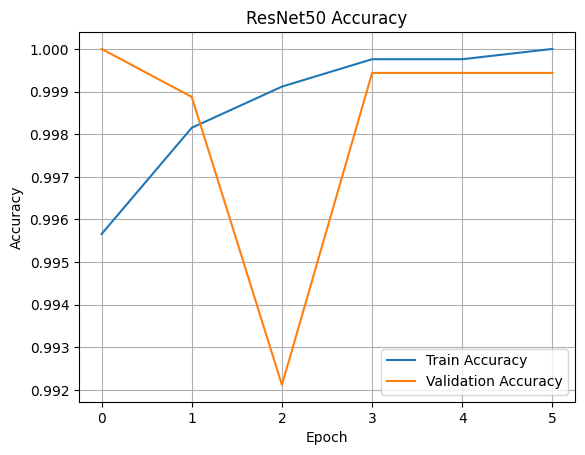

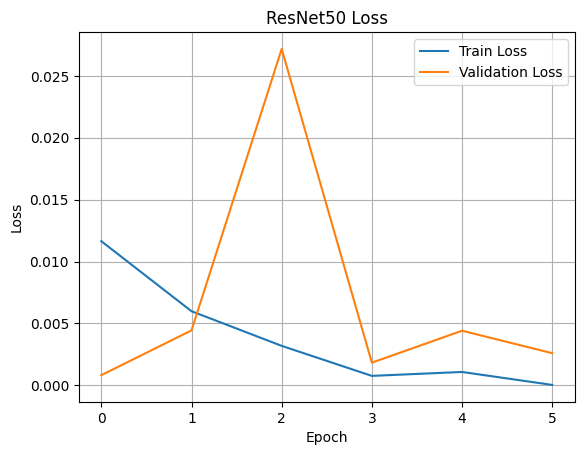

In [23]:
# Accuracy
plt.plot(resnet_history.history['accuracy'], label='Train Accuracy')
plt.plot(resnet_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet50 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(resnet_history.history['loss'], label='Train Loss')
plt.plot(resnet_history.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


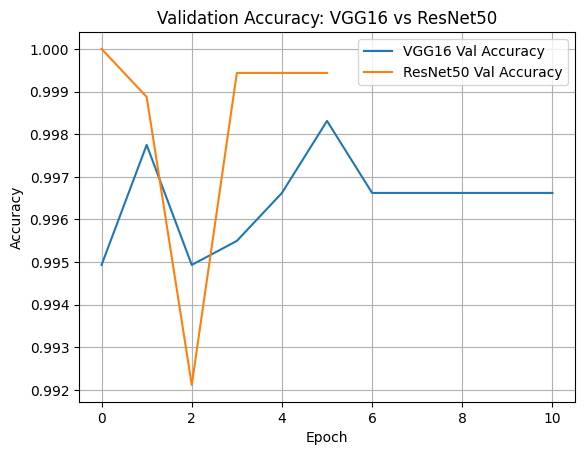

In [24]:
#Compare Validation Accuracy in Vgg vs ResNet50
plt.plot(vgg_history.history['val_accuracy'], label='VGG16 Val Accuracy')
plt.plot(resnet_history.history['val_accuracy'], label='ResNet50 Val Accuracy')
plt.title('Validation Accuracy: VGG16 vs ResNet50')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


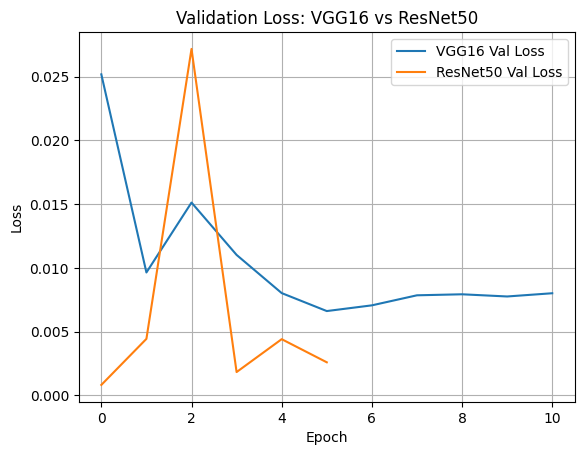

In [25]:
#Comparing Validation Loss
plt.plot(vgg_history.history['val_loss'], label='VGG16 Val Loss')
plt.plot(resnet_history.history['val_loss'], label='ResNet50 Val Loss')
plt.title('Validation Loss: VGG16 vs ResNet50')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
